In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input
import pprint as pp
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df = df[(df["item"]==1) & (df['store']==1)] # Store 1 and item 1 only
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

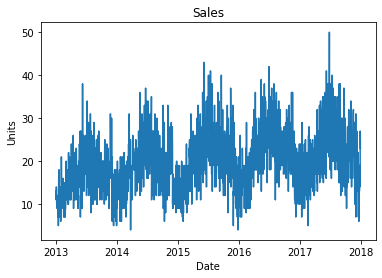

In [ ]:
plt.plot(df['date'],df['sales'])
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

In [ ]:
raw_seq = df['sales']

In [ ]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
def cnn_model(hp):
  model = tf.keras.Sequential() 
  model.add(Input(shape=(30,1)))

  num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
  k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

  model.add(Conv1D(num_filters, k_size, activation='relu'))
  if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    model.add(MaxPooling1D())
  else:
    model.add(AveragePooling1D())
     
  model.add(Flatten())
  model.add(Dense(hp.Int('units_fully_connected_dense', min_value=16, max_value=512, step=16), activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

In [ ]:
tuner = kt.tuners.Hyperband(
    cnn_model,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='cnn_exp',
    project_name='demand forecasting')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters_cnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
pooling_ (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
units_fully_connected_dense (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}


In [ ]:
X, y = split_sequence(raw_seq, n_steps=5)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = mlp_model(n_steps)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[stop_early])

Trial 450 Complete [00h 00m 11s]
val_mean_squared_error: 37.088226318359375

Best val_mean_squared_error So Far: 34.300376892089844
Total elapsed time: 00h 26m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in cnn_exp/demand forecasting
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
filters_cnn_layer: 304
kernel_size: 2
pooling_: avg
units_fully_connected_dense: 432
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 34.300376892089844
Trial summary
Hyperparameters:
filters_cnn_layer: 480
kernel_size: 2
pooling_: avg
units_fully_connected_dense: 336
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 34.30177688598633
Trial summary
Hyperparameters:
filters_cnn_layer: 112
kernel_size: 2
pooling_: avg
units_fully_connected_dense: 400
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 34.33106231689453
Trial summary
Hyperparameters:
filters_cnn_layer: 192
kernel_size: 2
pooling_: avg
units_fully_connected_dense: 320
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 34.34675598144531
Trial summar